## Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, rfft, fftfreq, fftshift
from scipy import signal
import scipy.io.wavfile as wavfile

## Functions

In [3]:
# wavFileLocation - file location of the .wav file
# timeStep - the step at time at which a fourier transformation is performed
def WavToFFT(wavFileLocation, timeStep):
    fftList = []

    # Step 1) Retrieve Wav File
    try:
        sampleRate, wavSignal = wavfile.read(wavFileLocation)
    except:
        print(f"ERROR: could not open {wavFileLocation} file")

    # Step 2) Define Time Step
    newSampleRate = sampleRate * timeStep
    currSample = 0

    # Step 3) Iterate over signal
    while currSample < np.size(wavSignal):
        fftList.append(fft(wavSignal[int(currSample):int(currSample)+int(newSampleRate)]))
        currSample += int(newSampleRate)
    
    fftList = fftList[:-1] # remove last part in case it's not homogenous (i.e. not the same length as rest of values in list)
    return fftList, wavSignal, sampleRate


def reduceXMatrix(xMatrix, PCATruncationValue):
    # Perform SVD
    U, S, Vt = np.linalg.svd(xMatrix, full_matrices=False)

    # Truncation Matrix
    diagonal = np.zeros(np.size(S), dtype=int)
    diagonal[:PCATruncationValue] = 1   

    print(np.size(S))
    # View PCA and truncate S
    S *= diagonal

    return np.dot(U, np.dot(np.diag(S), Vt))

def outputFFTArr(fftArr, sampleRate):
    reconstructedArr = []
    for fftSegment in fftArr:
        reconstructedArr.append(ifft(fftSegment).real)
    wavfile.write('reconstructed.wav', sampleRate, np.concatenate(reconstructedArr).astype(np.float32))
    

## Main

19


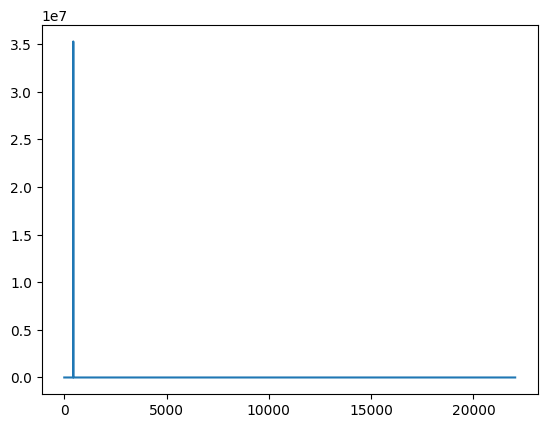

In this case, the sine wave is moving at 440.0 Hz
Compare this YouTube video of a sine wave at 440 hz https://www.youtube.com/watch?v=xGXYFJmvIvk&t=29s and the sine.wav file
you'll notice that they sound the same showing that the fft is working accordingly


In [8]:
if __name__ == "__main__":
    # Testing output of FFT
    # In this case, the .wav file is being sampled every 0.1 seconds
    # TODO: posibly implement NMF beforehand
    # TODO: possibly change sample rate to change based on beat (i.e. detect quarter notes, whole notes, half notes, etc...)
    fftArr, wavSignal, sampleRate = WavToFFT("SampleWavFiles\sine.wav", 0.1)
    
    # Perform PCA to extract principle frequencies
    # TODO: Research truncation value
    fftArr = reduceXMatrix(np.array(fftArr), 200)
    
    # Filter all but the top 1% of values (statistical thresholding)
    for i, val in enumerate(fftArr):
        sortedVals = np.sort(np.abs(val))[::-1]
        val[np.abs(val) < sortedVals[int(np.size(sortedVals) * 0.01)]] = 0.0
    
    # Example of converting the FFT to a graph
    frequencies = fftfreq(len(fftArr[1]), 1 / sampleRate)
    sinWaveX = frequencies[frequencies >= 0]
    sinWaveY = np.abs(fftArr[1])[frequencies >= 0]

    # Here is the plot of the sin wave
    plt.plot(sinWaveX, sinWaveY)
    plt.show()

    # Here is the frequency
    sinWaveFrequency = sinWaveX[np.argmax(sinWaveY)]
    print(f"In this case, the sine wave is moving at {sinWaveFrequency} Hz")
    print(f"Compare this YouTube video of a sine wave at 440 hz https://www.youtube.com/watch?v=xGXYFJmvIvk&t=29s and the sine.wav file")
    print(f"you'll notice that they sound the same showing that the fft is working accordingly")

    # reconstruct wave
    outputFFTArr(fftArr, sampleRate)